In [1]:
#!git clone https://github.com/TheMrGhostman/Semi-supervised-Learning-with-VAE

In [2]:
#!pip install pyro-ppl

In [1]:
import os
import time

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision

from pyro.infer import SVI, JitTrace_ELBO, JitTraceEnum_ELBO, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

import matplotlib.pyplot as plt


In [2]:
#os.chdir("Semi-supervised-Learning-with-VAE/")

In [3]:
from utils.datasets import SupervisedDataset
from utils.utils import One_Hot
from utils.inception import *

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from utils.layers import Reshape, Flatten
import utils.datasets as d

In [5]:
class VariationalLayer(nn.Module):
    """
    Variational Layer with reparametrization trick. 
    It's used as bottleneck of Variational AutoEncoder ie. output of encoder.

    "Linear layer for variational inference with reparametrization trick"
    """
    def __init__(self, in_features, out_features, bias=True):
        """	
        : param in_features: 		Number of input features (number of neurons on input)
        : param out_features:		Number of output features (number of neurons on output)
        : param bias:				Include bias - True/False
        """
        super(VariationalLayer, self).__init__()
        self.mu = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.rho = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        mu = self.mu(x_in)
        sigma = self.softplus(self.rho(x_in))
        return mu, sigma

In [6]:
class ConvTransposeDecoderOutput(nn.Module):
    def __init__(self, in_channels, in_features, out_features, kernel_size, stride=1, padding=0, bias=True):
        super(ConvTransposeDecoderOutput, self).__init__()
        self.mu = nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=1, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
            )
        self.rho = nn.Linear(in_features=in_features, out_features=1, bias=bias)
        self.flatten = Flatten(out_features=in_features)
        self.flatten_mu = Flatten(out_features=out_features)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        """
        x must be shape ... (-1, in_channels, size)
        """
        mu = self.mu(x_in)
        x = self.flatten(x_in)
        sigma = self.softplus(self.rho(x))
        return self.flatten_mu(mu), sigma

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.first_part =  nn.Sequential(
                Reshape(out_shape=(1, 160)),
                nn.Conv1d(in_channels=1, out_channels=16, kernel_size=6, stride=2, padding=0, bias=False), # n*1*160 -> n*16*78
                nn.PReLU(),
                nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, bias=False),#n*16*78->n*32*38
                nn.BatchNorm1d(num_features=32),
                nn.PReLU(),
                nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, bias=False),#n*32*38->n*64*18
                nn.BatchNorm1d(num_features=64),
                nn.PReLU(),
                Flatten(out_features=64*18))
        self.fc = nn.Linear(in_features=64*18+4, out_features=256)
        self.act = nn.PReLU()
        self.out = VariationalLayer(in_features=256, out_features=15)
        
    def forward(self, x,y):
        z = self.first_part(x)
        z = torch.cat([z,y], axis=1)
        z = self.act(self.fc(z))
        return self.out(z)
        

In [9]:
decoder = nn.Sequential(
    nn.Linear(in_features=15+4, out_features=256),
    nn.PReLU(),
    nn.Linear(in_features=256, out_features=64*18),
    Reshape(out_shape=(64,18)),
    nn.BatchNorm1d(num_features=64),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0),
    nn.BatchNorm1d(num_features=32),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=0),
    #nn.BatchNorm1d(num_features=16),
    nn.PReLU(),
    ConvTransposeDecoderOutput(
        in_channels=16,
        in_features=16*78,
        out_features=160, 
        kernel_size=6, 
        stride=2
        )
    )

In [10]:
# InceptionTime model
clf = nn.Sequential(
        Reshape(out_shape=(1,160)),
        InceptionBlock(
            in_channels=1, 
            n_filters=32, 
            kernel_sizes=[5, 11, 23],
            bottleneck_channels=32,
            use_residual=True,
            activation=nn.ReLU()
        ),
        InceptionBlock(
            in_channels=32*4, 
            n_filters=32, 
            kernel_sizes=[5, 11, 23],
            bottleneck_channels=32,
            use_residual=True,
            activation=nn.ReLU()
        ),
        nn.AdaptiveAvgPool1d(output_size=1),
        Flatten(out_features=32*4*1),
        nn.Linear(in_features=4*32*1, out_features=4),
        nn.Softmax(dim=1)
    )

In [11]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the MNIST image dataset
    :param output_size: size of the tensor representing the class label (10 for MNIST since
                        we represent the class labels as a one-hot vector with 10 components)
    :param input_size: size of the tensor representing the image (28*28 = 784 for our MNIST dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (handwriting style for our MNIST dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super().__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = 4
        self.z_dim = 15
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        self.encoder_y = clf

        self.encoder_z = Encoder()

        self.decoder = decoder

        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # handwriting style (latent)
        p(y|x) = categorical(I/10.)     # which digit (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = torch.ones(batch_size, self.output_size, **options) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = normal(decoder(y,z))
            # where `decoder` is a neural network
            mu, sigma = self.decoder(torch.cat([zs, ys], axis=1))
            #mu = self.decoder(torch.cat([zs, ys], axis=1))
            #pyro.sample("x", dist.Normal(mu,torch.ones((mu.shape[0],1)).cuda()).to_event(1), obs=xs)
            pyro.sample("x", dist.Normal(mu,sigma).to_event(1), obs=xs)
            # return the loc so we can visualize it later
            return mu

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer digit from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer handwriting style from an image and the digit
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z(xs, ys)
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = torch.zeros_like(alpha).scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [12]:
def get_accuracy(data_loader, clf):
    """
        clf ... ssvae.classifier()
    """
    dataloader_len = len(data_loader)
    acc = 0
    with torch.no_grad():
        for (xs, ys) in data_loader:
            xs = xs.cuda()
            pred = clf(xs)
            acc += accuracy_score(np.argmax(pred.cpu().detach().numpy(), axis=1) , np.argmax(ys.numpy(),axis=1))
    return acc/dataloader_len

In [13]:
def run_inference_for_epoch(data_loaders, losses):
    """
        thanks to random sampler supervised and unsupervised datasets have the same length

        two losses -> [ ELBO , -E(q(y|x)) ]
    """
    num_losses = len(losses) 

    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])
    
    #model.train()
    for batch_idx  in range(len(data_loaders["unsup"])):
        
        # supervised flow
        (xs, ys) = next(sup_iter)
        for loss_id in range(num_losses):
            # evaluating (tracing) losses and optimizer step 
            new_loss = losses[loss_id].step(xs.cuda(), ys.cuda())
            # saving losses 
            epoch_losses_sup[loss_id] += new_loss
        

        # unsupervised flow
        xs = next(unsup_iter)
        for loss_id in range(num_losses):
            # evaluating (tracing) losses and optimizer step 
            new_loss = losses[loss_id].step(xs.cuda())
            # saving losses
            epoch_losses_unsup[loss_id] += new_loss

            
    return epoch_losses_sup, epoch_losses_unsup

# Get Data

In [14]:
X_s = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y_s = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [15]:
X_u = np.vstack((np.load("data/unlabeled_sequences_part_1.npy"), np.load("data/unlabeled_sequences_part_2.npy")))

In [16]:
print(X_s.shape)
print(X_u.shape)

(83680, 160)
(97400, 160)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_s), np.array(y_s), test_size=0.2, random_state=666)

In [18]:
scaler = RobustScaler()
scaler.fit(np.vstack((np.array(X_s),np.array(X_u))))

X_sup= scaler.transform(X_train)
X_unsup = scaler.transform(np.array(X_u))
X_test = scaler.transform(X_test)

In [19]:
X_sup.shape

(66944, 160)

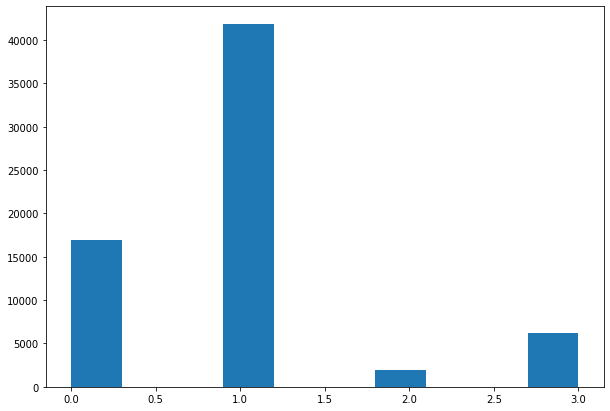

In [25]:
plt.figure(figsize=(10,7))
plt.hist(y_train)
plt.show()

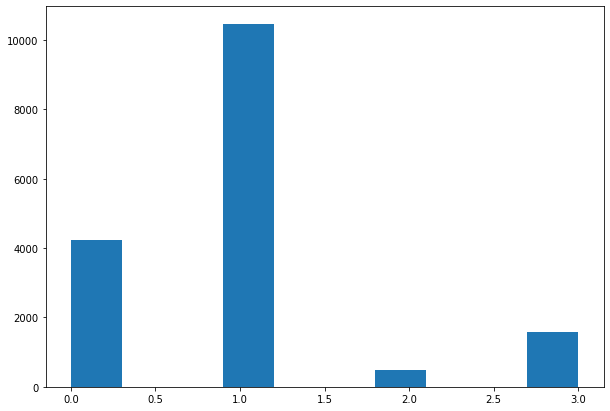

In [24]:
plt.figure(figsize=(10,7))
plt.hist(y_test)
plt.show()

# Defining model and inference

In [26]:
ss_vae = SSVAE(config_enum="parallel", use_cuda=True, aux_loss_multiplier=0.1*66944)# pyro exaples suggests 46 for MNIST

In [27]:
adam_params = {"lr": 0.0001}
optimizer = Adam(adam_params)

## ELBO of main loss $\mathcal{J} = \sum_{sup} \mathcal{L}(\vec{x},y) + \sum_{unsup} \mathcal{U}(\vec{x})$

In [28]:
guide = config_enumerate(ss_vae.guide, "sequential", expand=True) #config_enumerate(ss_vae.guide, "parallel", expand=True)
elbo = TraceEnum_ELBO(max_plate_nesting=1) #JitTraceEnum_ELBO
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

In [29]:
losses = [loss_basic]

## adding auxillary loss $\mathbb{E}_{sup}[-\log q(y|\vec{x})]$

In [30]:
elbo = Trace_ELBO()
loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
losses.append(loss_aux)

# Training

In [31]:
sup_num = X_unsup.shape[0]
unsup_num = X_unsup.shape[0]
best_valid_acc, corresponding_test_acc = 0.0, 0.0

In [32]:
batch_size = 512

In [33]:
sup = d.SupervisedDataset(X_sup, One_Hot(4)(y_train))
test = d.SupervisedDataset(X_test, One_Hot(4)(y_test))

In [34]:
data_loaders = {}
data_loaders["sup"] = torch.utils.data.DataLoader(
                            dataset=sup,
                            batch_size=batch_size, 
                            shuffle=False, 
                            sampler=torch.utils.data.RandomSampler(
                                sup, 
                                replacement=True,
                                num_samples=X_unsup.shape[0]
                                )
                            )
data_loaders["unsup"] = torch.utils.data.DataLoader(
                            dataset=torch.tensor(X_unsup).float(), 
                            batch_size=batch_size, 
                            shuffle=False, 
                            sampler=torch.utils.data.RandomSampler(
                                X_unsup, 
                                replacement=False
                                )
)
#data_loaders["valid"] = torch.utils.data.DataLoader(SupervisedDataset(X_train[-5000:].view(-1, 1,28,28), y_train[-5000:]), 
#                                                  batch_size=batch_size)
data_loaders["test"] = torch.utils.data.DataLoader(test, batch_size=batch_size)                                                  

In [35]:
sup_loss, unsup_loss, clf_loss, test_acc = [],[],[],[]


In [36]:
n_epochs = 50

In [37]:
for i in range(0,n_epochs): # 10 epochs for start
    start = time.time()
    epoch_sup_loss, epoch_unsup_loss = run_inference_for_epoch(data_loaders, losses)

    sup_loss.append(epoch_sup_loss[0]/sup_num)
    clf_loss.append(epoch_sup_loss[1]/sup_num)
    unsup_loss.append(epoch_unsup_loss[0]/unsup_num)

    test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
    test_acc.append(test_accuracy)

    
    print("Epoch [{}/{}], time {:.2f}s, sup_loss:{:.4f}, sup_clf_loss:{:.4f}, unsup_loss:{:.4f}, test_accuracy:{:.4f}"\
          .format(i+1, n_epochs, time.time()-start, sup_loss[-1], clf_loss[-1], unsup_loss[-1], test_accuracy))


Epoch [1/50], time 538.76s, sup_loss:3.7910, sup_clf_loss:3170.5262, unsup_loss:-23.9907, test_accuracy:0.8829
Epoch [2/50], time 538.55s, sup_loss:-95.1375, sup_clf_loss:2064.7858, unsup_loss:-125.1949, test_accuracy:0.9028
Epoch [3/50], time 551.56s, sup_loss:-125.6118, sup_clf_loss:1792.6574, unsup_loss:-150.3259, test_accuracy:0.9151
Epoch [4/50], time 567.21s, sup_loss:-142.3999, sup_clf_loss:1635.4805, unsup_loss:-165.7822, test_accuracy:0.9162
Epoch [5/50], time 567.87s, sup_loss:-153.6416, sup_clf_loss:1527.3140, unsup_loss:-175.7674, test_accuracy:0.9104
Epoch [6/50], time 573.59s, sup_loss:-159.8302, sup_clf_loss:1413.0117, unsup_loss:-180.9021, test_accuracy:0.9242
Epoch [7/50], time 578.24s, sup_loss:-161.4024, sup_clf_loss:1352.8652, unsup_loss:-184.8013, test_accuracy:0.9227
Epoch [8/50], time 581.42s, sup_loss:-170.6576, sup_clf_loss:1289.1355, unsup_loss:-192.0674, test_accuracy:0.9291
Epoch [9/50], time 558.12s, sup_loss:-168.9978, sup_clf_loss:1181.2017, unsup_loss:-1

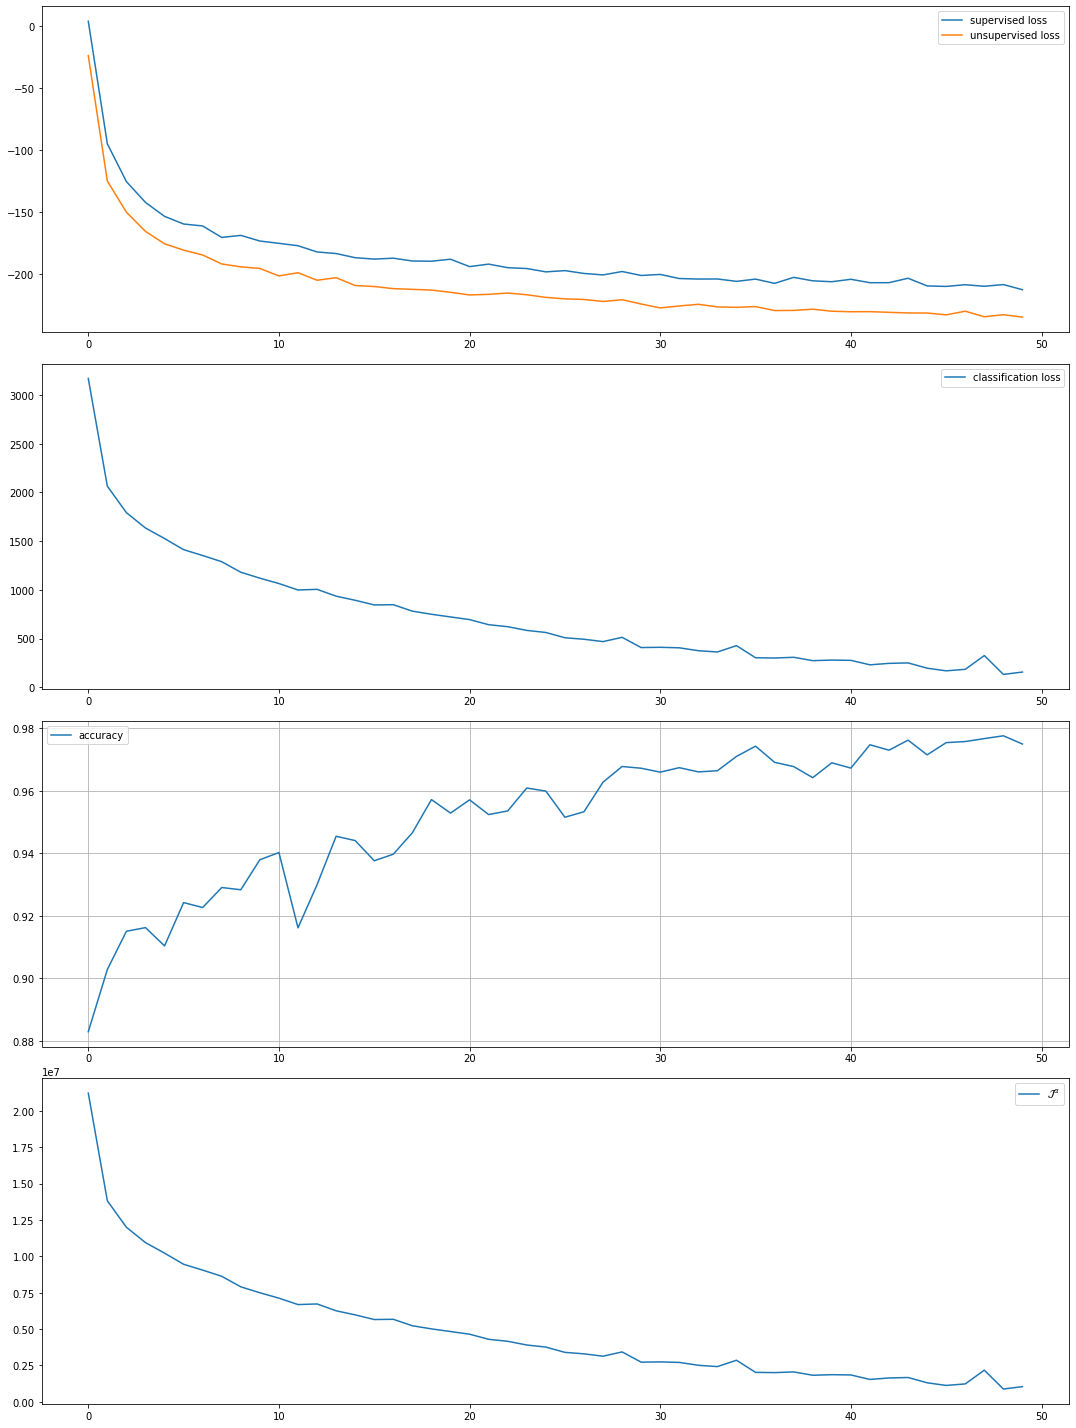

In [39]:
alpha = 0.1*66944
fig, axes = plt.subplots(4,1, figsize=(15,20))
fig.tight_layout()
axes[0].plot(np.array(sup_loss), label="supervised loss")
axes[0].plot(np.array(unsup_loss), label="unsupervised loss")
axes[0].legend()

axes[1].plot(np.array(clf_loss), label="classification loss")
axes[1].legend()

axes[2].plot(np.array(test_acc), label="accuracy")
axes[2].grid(True)
axes[2].legend()

axes[3].plot(np.array(sup_loss) + np.array(unsup_loss)  + alpha * np.array(clf_loss), label=r"$\mathcal{J}^{\alpha}$")
axes[3].legend()
plt.show()

In [40]:
torch.save(ss_vae, "models_and_losses/SSVAE_InceptionTime_proper_scale_lr-1e-4_50ep.pt")
torch.save(ss_vae.state_dict(), "models_and_losses/SSVAE_InceptionTime_proper_scale_lr-1e-4_state_dict_50ep.pt")
torch.save(ss_vae.encoder_y, "models_and_losses/SSVAE_InceptionTime_proper_scale_classifier_lr-1e-4_50ep.pt")
torch.save(ss_vae.encoder_y.state_dict(), "models_and_losses/SSVAE_InceptionTime_proper_scale_classifier_lr-1e-4_state_dict_50ep.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SSVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VariationalLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvTransposeDecoderOutput. It won't be chec

In [41]:
import pandas as pd

df = pd.DataFrame({"supervised_loss":sup_loss, "unsupervised_loss":unsup_loss, "classification_loss":clf_loss,  "test_accuracy":test_acc})
df.head()

,supervised_loss,unsupervised_loss,classification_loss,test_accuracy
0,3.790969,-23.990682,3170.526222,0.882942
1,-95.137534,-125.194930,2064.785821,0.902850
2,-125.611761,-150.325867,1792.657386,0.915074
3,-142.399949,-165.782175,1635.480496,0.916242
4,-153.641615,-175.767372,1527.314026,0.910393


In [42]:
df.to_csv("models_and_losses/SSVAE_CBN_proper_scale_lr-1e-4_100ep_losses.csv")

In [43]:
#pred = ss_vae.encoder_y(torch.tensor(X_test).float().cuda())
preds = []
ss_vae.encoder_y.eval()
with torch.no_grad():
    for (xs, ys) in data_loaders["test"]:
        xs = xs.cuda()
        pred = ss_vae.encoder_y(xs)
        preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))



In [44]:
preds = np.hstack(preds)

In [45]:
f1_score(y_true=y_test, y_pred=preds,average="macro")

0.9406177712415476

In [46]:
accuracy_score(y_true=y_test, y_pred=preds)

0.9768164435946463

In [47]:
cf1 = confusion_matrix(y_true=y_test, y_pred=preds) # x_axis = predicted, y_axis = ground_truth
cf1

array([[ 4051,    42,    21,   121],
       [   18, 10416,     1,    10],
       [   34,     3,   428,    14],
       [   69,    20,    35,  1453]], dtype=int64)

       
       [[ 3805,   296,    27,   107],
       [   91, 10307,     8,    39],
       [   22,     8,   425,    24],
       [  169,    37,    20,  1351]] 
       InceptionTime best model so far
       